In [72]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchinfo import summary

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

import numpy as np

# device = "cuda"
device= "mps"

In [73]:
%matplotlib inline

In [74]:
# !pip install gdown
# !pip install scipy

# We are going to use the Calthech101 dataset

In [75]:
class ConvertToRGB(object):
    def __call__(self, image):
        if image.mode == 'RGB':
            return image
        elif image.mode == 'L':
            return image.convert('RGB')
        else:
            raise ValueError(f'Unsupported image mode: {image.mode}')





transform = T.Compose([
    ConvertToRGB(),
    T.Resize((224, 224)),
    T.ToTensor(),
    # Add other transforms as needed
])

dataset = torchvision.datasets.Caltech101(root=Path.cwd(), 
                                          target_type = 'category', 
                                          transform = transform, 
                                          target_transform = None, 
                                          download= True)

dataloader = DataLoader(dataset, batch_size=32)



Files already downloaded and verified


the dataset includes 8677 samples


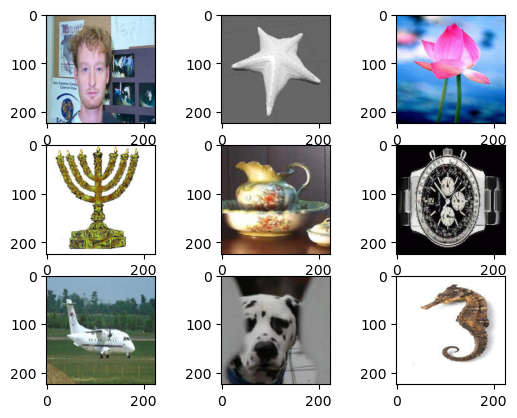

In [76]:
indexes = np.random.randint(0, len(dataset), (3,3))

fig, axes = plt.subplots(3,3)

for i in range(3):
    for j in range(3):
        img, _ = dataset[indexes[i,j]]
        axes[i,j].imshow(img.permute(1,2,0))

# Dataset presentation : 
print(f"the dataset includes {len(dataset)} samples")

# Model creation

In [77]:
D = 768
N = 100

z = torch.randn((N, D))

In [78]:
z.shape
# z.to(device)

torch.Size([100, 768])

In [79]:
class SelfAttention(nn.Module):
    def __init__(self, D_input, D_h):
        super().__init__()
        self.D_h = D_h
        self.D_input=D_input

        self.q_mat = nn.Linear(in_features=self.D_input, out_features=self.D_h, bias=None)
        self.k_mat = nn.Linear(in_features=self.D_input, out_features=self.D_h, bias=None)
        self.v_mat = nn.Linear(in_features=self.D_input, out_features=self.D_h, bias=None)
    
    def forward(self, z):
        q, k, v = self.q_mat(z), self.k_mat(z), self.v_mat(z)
        A = torch.softmax(torch.matmul(q, torch.transpose(k, 1, 0)) / torch.sqrt(torch.tensor(self.D_h)), axis=1)
        return torch.matmul(A, v)
        

# class MSA(nn.Module): # PROBLEM WITH MEMORY MANAGEMENT BECAUSE OF THE LIST
#     def __init__(self, embedding_dim, num_heads):
#         super().__init__()
#         self.k = num_heads
#         self.D_input = embedding_dim
#         self.D_h = embedding_dim//num_heads

#         self.attentions = [SelfAttention(self.D_h, self.D_h) for i in range(self.k)]
#         self.unification_matrix = nn.Linear(self.D_input, self.D_input, bias=None)
    
#     def forward(self, z):
#         vectors = torch.split(z, split_size_or_sections=self.D_h, dim=1)

#         for i in range(self.k):
#             vectors[i] = self.attentions[i](vectors[i])

#         MSA = torch.cat(vectors, dim=1)
#         return self.unification_matrix(MSA)
    

class MSA(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)
        # for q, k, v, instead of having k linear layers acting in parallel with shape nn.Linear(embedding_dim, embedding_dim/k), 
        # they are all stacked together in one layer, and we cut the output afterwards.



    def forward(self, x):
        N, seq_length, embedding_dim = x.shape

        # Split the embedding into self.num_heads different pieces
        # view : see the vector reshaped as "", without copying i.e. do specific operations easily
        queries = self.query(x).view(N, seq_length, self.num_heads, self.head_dim)
        keys = self.key(x).view(N, seq_length, self.num_heads, self.head_dim)
        values = self.value(x).view(N, seq_length, self.num_heads, self.head_dim)

        # Transpose to get dimensions (N, num_heads, seq_length, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calculate the attention scores
        scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale
        attention = torch.softmax(scores, dim=-1)

        # Get the weighted values
        out = torch.matmul(attention, values)

        # Reshape to (N, seq_length, embedding_dim)
        out = out.transpose(1, 2).contiguous().view(N, seq_length, embedding_dim)

        # Apply the final linear layer (unification layer)
        out = self.fc_out(out)
        return out

class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_size, dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mlp_size = mlp_size
        
        self.block = nn.Sequential(nn.LayerNorm(normalized_shape=self.embedding_dim),
                        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
                        nn.GELU(),
                        nn.Dropout(dropout),
                        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
                        nn.Dropout(dropout))

    def forward(self, z):
        return self.block(z)


# Main difference between Self attention and MSA : get less computations in matrix multiplications.


In [24]:
sa = SelfAttention(D, D)
print(sa(z).shape)
print(f"Q: {sa.q_mat._parameters['weight'].shape}, K: {sa.k_mat._parameters['weight'].shape}, V: {sa.q_mat._parameters['weight'].shape}")

summary(sa)

# msa = MSA(embedding_dim=768, num_heads=16)
# output_attention = msa.forward(z)
# print(output_attention.shape)

torch.Size([100, 768])
Q: torch.Size([768, 768]), K: torch.Size([768, 768]), V: torch.Size([768, 768])


Layer (type:depth-idx)                   Param #
SelfAttention                            --
├─Linear: 1-1                            589,824
├─Linear: 1-2                            589,824
├─Linear: 1-3                            589,824
Total params: 1,769,472
Trainable params: 1,769,472
Non-trainable params: 0

In [25]:
msa = MSA(embedding_dim=768, num_heads=16)

summary(msa)

Layer (type:depth-idx)                   Param #
MSA                                      --
├─Linear: 1-1                            590,592
├─Linear: 1-2                            590,592
├─Linear: 1-3                            590,592
├─Linear: 1-4                            590,592
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0

In [41]:
class Encoder(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                mlp_size:int=3072, 
                mlp_dropout:float=0.1, 
                attn_dropout:float=0):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout
        self.attn_dropout = attn_dropout

        self.norm = nn.LayerNorm(normalized_shape=self.embedding_dim)

        self.MSA = MSA(self.embedding_dim, self.num_heads)
        self.MLP = MLP(embedding_dim=self.embedding_dim, mlp_size=self.mlp_size, dropout=self.mlp_dropout)

    
    def forward(self, x):
        att_x = self.MSA(self.norm(x)) + x

        mlp_x = self.MLP(self.norm(att_x)) + x 
        return mlp_x

class PatchEmbedder(nn.Module):

    def __init__(self, patch_size: int, embedding_dim:int = 768, patch_num=196, random=True):
        super().__init__()

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.patch_num = patch_num

        self.conv = nn.Conv2d(in_channels=3, out_channels=embedding_dim, 
                              kernel_size=(patch_size, patch_size), stride=patch_size, padding=0)
                            # donne en gros le meme resultat que couper en petits patches, flatten et passer dans une linear layer
        self.flat = nn.Flatten(start_dim=2, end_dim=3)

        # ADD [CLASS] TOKEN
        if random:
            self.class_embedding= nn.Parameter(torch.rand((1, 1, embedding_dim)), requires_grad=True)
        else:
            self.class_embedding= nn.Parameter(torch.ones((1, 1, embedding_dim)), requires_grad=True)

        # ADD POSITION EMBEDDING
        if random:
            self.pos_embedding= nn.Parameter(torch.ones((1, patch_num+1 , embedding_dim)), requires_grad=True)
        else:
            self.pos_embedding= nn.Parameter(torch.rand((1, patch_num+1 , embedding_dim)), requires_grad=True)
        # Add the position embedding to the patch and class token embedding

    def forward(self, x):
        batch_size = x.shape[0]
        

        y = self.flat(self.conv(x))
        y = y.permute(0, 2, 1)
        
        return torch.cat((self.class_embedding.expand(batch_size, -1, -1), y),dim=1) + self.pos_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2011, 0.8645, 0.7006,  ..., 0.7857, 1.2222, 1.0275],
         [1.3647, 0.5986, 0.4900,  ..., 0.5605, 1.3042, 1.1733],
         ...,
         [1.1470, 0.8408, 0.7463,  ..., 0.7673, 1.1900, 1.0390],
         [1.1174, 0.8074, 0.7739,  ..., 0.7508, 1.1860, 1.0342],
         [1.1217, 0.8369, 0.7548,  ..., 0.7625, 1.1813, 1.0399]],

        [[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0387, 0.7383, 0.7512,  ..., 0.7036, 1.2736, 1.0232],
         [0.9519, 0.9033, 0.8317,  ..., 0.8021, 1.1918, 1.0488],
         ...,
         [1.4017, 0.7537, 0.5754,  ..., 0.6906, 1.4013, 1.2022],
         [1.2625, 0.7392, 0.6581,  ..., 0.5867, 1.3004, 1.1638],
         [1.2818, 0.6846, 0.6578,  ..., 0.5965, 1.2597, 1.0462]],

        [[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.3785, 0.4708, 0.1411,  ..., 0.3886, 1.5325, 1.3381],
         [1.4899, 0.3952, 0.0811,  ..., 0.2651, 1.5902, 1.

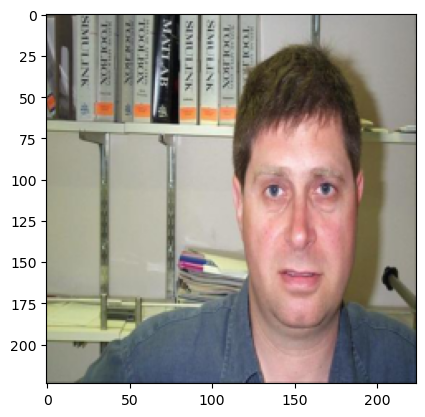

In [38]:
plt.imshow(next(iter(dataloader))[0][0].permute(1, 2, 0))

embedder = PatchEmbedder(patch_size=16, embedding_dim=768)
embedder(next(iter(dataloader))[0])

In [39]:
def train(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    # Dictionary to store losses
    losses = {'train_loss': [], 'test_loss': []}
    
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model parameters
            
            running_train_loss += loss.item() * inputs.size(0)  # Accumulate loss
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        losses['train_loss'].append(epoch_train_loss)
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        
        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                
                running_test_loss += loss.item() * inputs.size(0)  # Accumulate loss
        
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        losses['test_loss'].append(epoch_test_loss)
        
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    
    return losses

# Example usage:
# model = MyModel().to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# n_epochs = 10
# losses = train(model, train_loader, test_loader, criterion, optimizer, n_epochs)

In [43]:
class ViT(nn.Module):
    def __init__(self,
                    img_size:int=224, # Training resolution from Table 3 in ViT paper
                    in_channels:int=3, # Number of channels in input image
                    patch_size:int=16, # Patch size
                    num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                    embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                    mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                    num_heads:int=12, # Heads from Table 1 for ViT-Base
                    attn_dropout:float=0, # Dropout for attention projection
                    mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                    embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                    num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.img_size = img_size
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.patch_num = (self.img_size//self.patch_size)**2

        self.num_transformer_layers = num_transformer_layers
        self.embedding_dim = embedding_dim
        self.mlp_size = mlp_size
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        self.mlp_dropout = mlp_dropout
        self.embedding_dropout = embedding_dropout
        self.num_classes = num_classes

        self.Embedding = PatchEmbedder(patch_size=self.patch_size,
                                        embedding_dim=self.embedding_dim,
                                        patch_num=self.patch_num, random=True)
        
        self.EmbeddingDropout = nn.Dropout(p=self.embedding_dropout)
        
        self.StackedEncoders = nn.Sequential(*[Encoder(embedding_dim=self.embedding_dim, 
                                                num_heads=self.num_heads,
                                                mlp_size=self.mlp_size,
                                                mlp_dropout=self.mlp_dropout,
                                                attn_dropout=self.attn_dropout)
                                        for layer in range(self.num_transformer_layers)])
        self.Classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

        def forward(x):
            
            embedded_x = self.EmbeddingDropout(self.Embedding(x))

            embedded_x = self.StackedEncoders(embedded_x)
            
            class_x = self.Classifier(x)

            return class_x[:,0]

            


In [50]:
vit= ViT(num_classes=len(dataset.categories))
summary(model=vit)
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )


Layer (type:depth-idx)                        Param #
ViT                                           --
├─PatchEmbedder: 1-1                          152,064
│    └─Conv2d: 2-1                            590,592
│    └─Flatten: 2-2                           --
├─Dropout: 1-2                                --
├─Sequential: 1-3                             --
│    └─Encoder: 2-3                           --
│    │    └─LayerNorm: 3-1                    1,536
│    │    └─MSA: 3-2                          2,362,368
│    │    └─MLP: 3-3                          4,723,968
│    └─Encoder: 2-4                           --
│    │    └─LayerNorm: 3-4                    1,536
│    │    └─MSA: 3-5                          2,362,368
│    │    └─MLP: 3-6                          4,723,968
│    └─Encoder: 2-5                           --
│    │    └─LayerNorm: 3-7                    1,536
│    │    └─MSA: 3-8                          2,362,368
│    │    └─MLP: 3-9                          4,723,968
│  

101